In [1]:
import sys
sys.path.append('..')

import torch
import os
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from LOBnet.orderbook import FI2010_Orderbook_Optimized

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datapath = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "data", "BenchmarkDatasets_csv", "Auction", "1.Auction_Zscore", "Auction_Zscore_Testing"))
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 5

In [4]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=datapath,
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers,
    verbose=True
)

Processing CSV Files: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Raw price movement statistics:
Mean: 1.9958
Std: 0.8641
Min: 1.0000
Max: 3.0000

Label distribution:
0    2057
1    1388
2    2034
Name: count, dtype: int64


In [5]:
# Load dataset

batch_size = 32
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Test set size: {len(dataset)}")

Test set size: 5479


In [6]:
# Model imports
from LOBnet.final_models import BaselineDeepLOB, DeepLOB_Network_v2, TransformerLOB

In [7]:
# Model List
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {
    "baseline_model" : BaselineDeepLOB(y_len=3,device=device).to(device),
    "transformer_model" : TransformerLOB(y_len=3, device=device).to(device),
    "deepLOB_v2" : DeepLOB_Network_v2().to(device),
}

/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [8]:
# Ripped from updated_models

def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

Loading saved model from /Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/bestModels/baseline_model.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_19198/506619745.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locati


baseline_model:
Classification Report:
              precision    recall  f1-score   support

          Up     0.5176    0.5070    0.5123      2057
 No Movement     0.5655    0.5937    0.5793      1388
        Down     0.4998    0.4931    0.4964      2034

    accuracy                         0.5238      5479
   macro avg     0.5276    0.5313    0.5293      5479
weighted avg     0.5231    0.5238    0.5234      5479



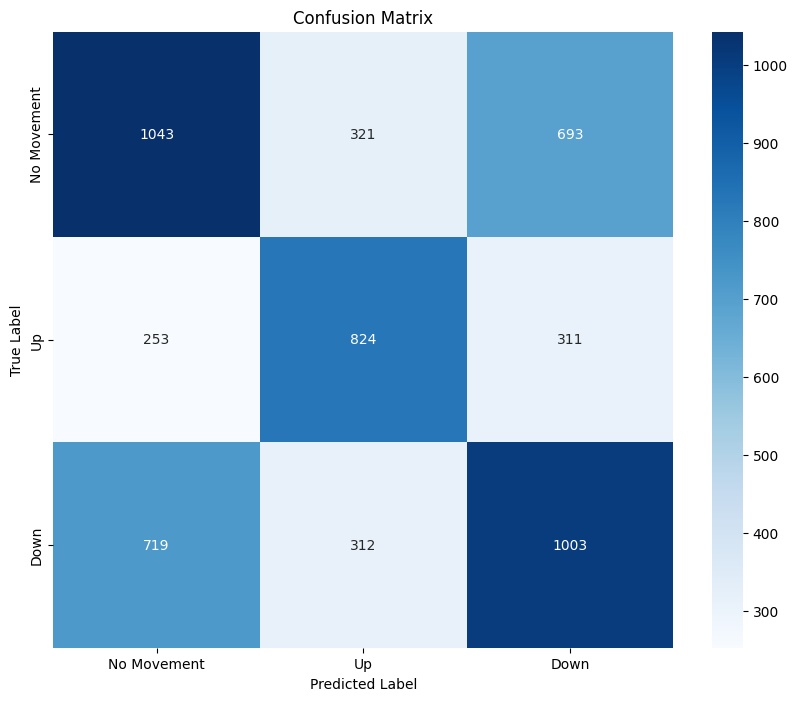

Loading saved model from /Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/bestModels/transformer_model.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_19198/506619745.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locati


transformer_model:
Classification Report:
              precision    recall  f1-score   support

 No Movement       0.68      0.69      0.68      2057
          Up       0.71      0.68      0.69      1388
        Down       0.69      0.69      0.69      2034

    accuracy                           0.69      5479
   macro avg       0.69      0.69      0.69      5479
weighted avg       0.69      0.69      0.69      5479



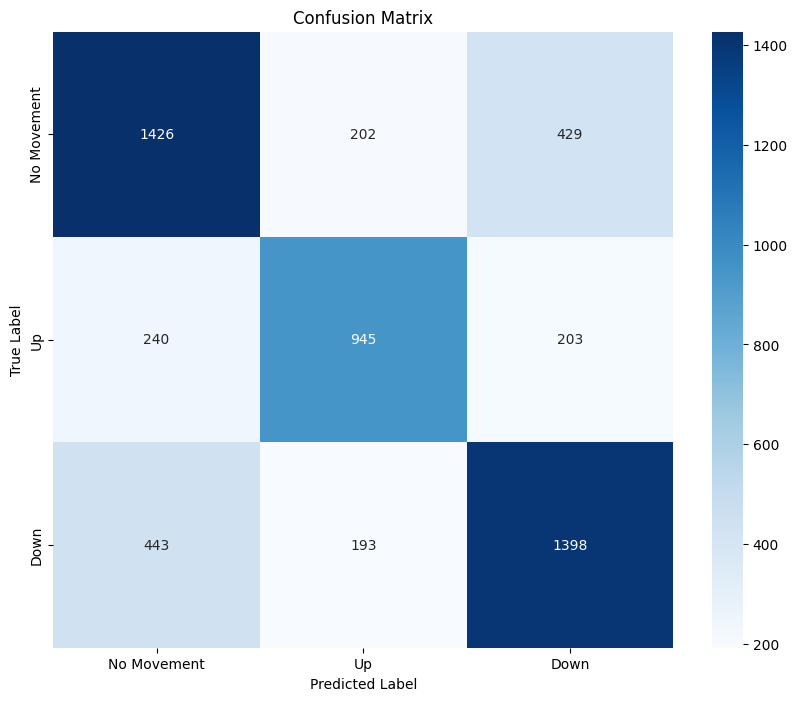

Loading saved model from /Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/bestModels/deepLOB_v2.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_19198/506619745.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locati


deepLOB_v2:
Classification Report:
              precision    recall  f1-score   support

 No Movement       0.72      0.70      0.71      2057
          Up       0.78      0.77      0.77      1388
        Down       0.72      0.74      0.73      2034

    accuracy                           0.73      5479
   macro avg       0.74      0.74      0.74      5479
weighted avg       0.73      0.73      0.73      5479



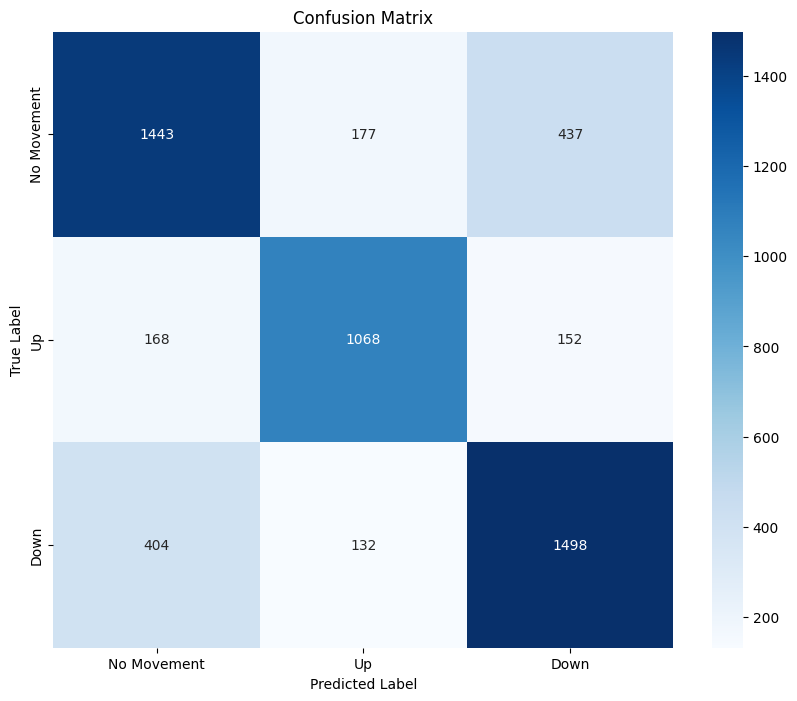

In [9]:
for model_name, model in models.items():
    model_path = os.path.abspath(os.path.join("..", "bestModels", model_name + ".pth"))
    if os.path.exists(model_path):
        print(f"Loading saved model from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()  # set to evaluation mode
        predictions, true_labels = evaluate_model(model, test_loader, device)

        print(f"\n{model_name}:\nClassification Report:")
        print(classification_report(true_labels, predictions, 
                                target_names=['Up', 'No Movement', 'Down'],
                                digits=4))

        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Up', 'No Movement', 'Down'],
                    yticklabels=['Up', 'No Movement', 'Down'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print(f"No saved model found at {model_path}. Please train the model first.")    

In [10]:
from PIL import Image, ImageDraw, ImageFont

# Define model names and accuracies
models_names = list(models.keys())
accuracies = [52.38, 68.79, 73.17]  # in percentage

# Create a bar chart using matplotlib
plt.figure(figsize=(6, 4))
plt.bar(models_names, accuracies, color=["skyblue", "lightgreen", "salmon"])
plt.ylim(0, 100)
plt.title("Model Accuracies", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the bar chart as an image
bar_chart_path = "bar_chart.png"
plt.savefig(bar_chart_path, bbox_inches='tight')
plt.close()

# Create a visually appealing image with PIL
width, height = 800, 600
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# Add title text
font_path = "/Library/Fonts/Arial.ttf"  # Update this to a valid font path if needed
title_font = ImageFont.truetype(font_path, 36)
draw.text((width // 2 - 200, 50), "Model Accuracy Comparison", font=title_font, fill="black")

# Add the bar chart to the image
bar_chart = Image.open(bar_chart_path)
bar_chart = bar_chart.resize((width - 100, height - 300))
image.paste(bar_chart, (50, 150))

# Save the final image
final_image_path = os.path.abspath(os.path.join("..", "acc.png"))
image.save(final_image_path)

print(f"The model accuracy display has been saved as {final_image_path}.")

The model accuracy display has been saved as /Users/tommydenezza/Desktop/DeepLearning/LOBnet/acc.png.
